### Annotate simulator images using Faster R-CNN

In [21]:
import os
import glob
import yaml
import cv2
import copy
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from random import shuffle
import ruamel.yaml

In [2]:
# Define data paths
DATA_FOLDER = os.path.join('.', 'data')
SIM_FOLDER = os.path.join(DATA_FOLDER, 'simulator')
ADDITIONAL_IMAGES_FOLDER = os.path.join(SIM_FOLDER, 'additional')
EXISTING_ANNOTATIONS_FILE = os.path.join(SIM_FOLDER, 'sim_data_annotations.yaml')
FASTER_RCNN_GRAPH = os.path.join('.', 'model', 'faster-rcnn_frozen.pb')
COCO_LABELS_FILE = os.path.join('.', 'labels', 'mscoco_label_map.pbtxt')

In [3]:
# Define constants
tl_labels = {"Green" : 1, "Red" : 2, "Yellow" : 3, "off" : 4}
tl_coco_class = 10
tl_detection_threshold = 0.80
image_h = 600
image_w = 800

In [13]:
# Read in all the image files.
sim_image_files = glob.glob(os.path.join(ADDITIONAL_IMAGES_FOLDER, '**','*.jpg'), recursive=True)
# Read in existing annotations
existing_annotations = yaml.load(open(EXISTING_ANNOTATIONS_FILE, 'r').read())
# Get classes for all images
sim_image_data = pd.DataFrame(sim_image_files, columns=['Path'])
sim_image_data['Class'] = sim_image_data.apply(lambda df: df['Path'].split(os.path.sep)[-2], axis=1)
# Boxes contain list of [ymin, xmin, ymax, xmax] boxes
sim_image_data['Boxes'] = None

In [5]:
# Load Faster-RCNN
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(FASTER_RCNN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [6]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

In [14]:
# Run inference on images
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        # Definite input and output Tensors for detection_graph
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        # Each box represents a part of the image where a particular object was detected.
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        for idx, row in tqdm(sim_image_data.iterrows(), total=len(sim_image_data)):
            image = Image.open(row['Path'])
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)
            # Actual detection.
            (boxes, scores, classes, num) = sess.run(
              [detection_boxes, detection_scores, detection_classes, num_detections],
              feed_dict={image_tensor: image_np_expanded})
            classes = np.squeeze(classes).astype(np.int32)
            boxes = np.squeeze(boxes)
            scores = np.squeeze(scores)
            # Check if detections include traffic lights
            traffic_lights = []
            for obj_class, score, box in zip(classes, scores, boxes):
                if obj_class == tl_coco_class:
                    if score is not None and score > tl_detection_threshold:
                        traffic_lights.append(box)
            sim_image_data.at[idx, 'Boxes'] = traffic_lights
                    

100%|████████████████████████████████████████████████████████████████████████████████| 755/755 [12:14<00:00,  1.03it/s]


In [23]:
new_annotations = []
# Extract and normalize boxes in existing annotations
for sample in existing_annotations:
    new_sample = {}
    new_sample['filename'] = 'data/simulator/'+sample['filename']
    new_sample['annotations'] = []
    for annotation in sample['annotations']:
        box = {}
        box['xmin'] = annotation['xmin']/image_w
        box['xmax'] = (annotation['xmin'] + annotation['x_width'])/image_w
        box['ymin'] = annotation['ymin']/image_h
        box['ymax'] = (annotation['ymin'] + annotation['y_height'])/image_h
        box['class'] = annotation['class']
        new_sample['annotations'].append(box)
    new_annotations.append(new_sample)

# Grab all the annotations from the additional dataset
for idx, row in sim_image_data.iterrows():
    new_sample = {}
    new_sample['filename'] = row['Path'][2:].replace('\\', '/')
    new_sample['annotations'] = []
    for annotation in row['Boxes']:
        box = {}
        box['xmin'] = annotation[1]
        box['xmax'] = annotation[3]
        box['ymin'] = annotation[0]
        box['ymax'] = annotation[2]
        box['class'] = row['Class']
        new_sample['annotations'].append(box)
    new_annotations.append(new_sample) 

In [30]:
existing_annotations[0]['annotations'][0]['x_width']

float

In [24]:
# Write all the annotations to file
def float_representer(dumper, value):
    text = '{0:.4f}'.format(value)
    return dumper.represent_scalar(u'tag:yaml.org,2002:float', text)
yaml.add_representer(float, float_representer)

shuffle(new_annotations)
with open('data\\simulator\\final_annotations.yaml', 'w') as outfile:
    yaml.dump(new_annotations, outfile)

### Augment & visualize the training data

In [239]:
def draw_boxes(img, boxes, color=(0, 0, 255), thick=3):
    # Make a copy of the image
    imcopy = np.copy(img)
    image_height = imcopy.shape[0]
    image_width = imcopy.shape[1]
    # Iterate through the bounding boxes
    for box in boxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, (int(box['xmin']*image_width), int(box['ymin']*image_height)), 
                      (int(box['xmax']*image_width), int(box['ymax']*image_height)), color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [297]:
def random_jitter_image(img, boxes, xlate_range):
    img_np = load_image_into_numpy_array(img)
    new_img = np.copy(img_np)
    
    height, width, channels = img_np.shape    
    xlate_x = np.random.uniform(xlate_range) - xlate_range/2
    xlate_y = np.random.uniform(xlate_range) - xlate_range/2
    M_xlate = np.float32([[1,0,xlate_x],[0,1,xlate_y]])
    #Transform image
    img_np = cv2.warpAffine(img_np, M_xlate, (width, height))
    #Transform boxes
    for box in boxes:
        box['xmin'] = box['xmin'] + xlate_x/width
        box['ymin'] = box['ymin'] + xlate_y/height 
        box['xmax'] = box['xmax'] + xlate_x/width 
        box['ymax'] = box['ymax'] + xlate_y/height
        
    return img_np, boxes

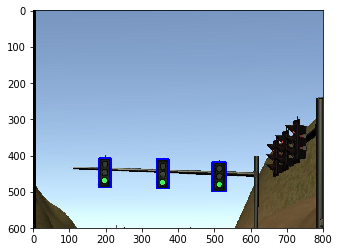

In [382]:
index = 50
test = Image.open(new_annotations[index]['filename'])
boxes = copy.deepcopy(new_annotations[index]['annotations'])
test_jitter, boxes_jitter = random_jitter_image(test, boxes, 20)
final_image = draw_boxes(test_jitter, boxes_jitter)
plt.imshow(final_image)
plt.show()

In [31]:
train_annotations_file = os.path.join(SIM_FOLDER, 'final_annotations.yaml')
loaded_annotations = yaml.load(open(train_annotations_file, 'rb').read())